In [1]:
%pylab inline
import requests
import json
import uvicorn
import bigfile

# import main

Populating the interactive namespace from numpy and matplotlib


# Get basic snapshot info

In [6]:
# This is our base url
base = "http://vm041.bridges.psc.edu:8001/"
response = requests.get(base)
print(response.url)
print(response.json())


http://vm041.bridges.psc.edu:8001/
{'msg': 'COSMO, a REST API for the BlueTides3 Cosmology Simulation Data'}


Now we want to look at the available snapshots and their basic information:

In [7]:
pig_url = base + "pig/"
response = requests.get(pig_url)
pig_list = json.loads(response.text)['LIST']
print('******************************PIG INFO*****************************')
for i in range(len(pig_list)):
    print('ID: ', pig_list[i]['id'],\
          ' FileName: ', pig_list[i]['name'], \
          ' Num halos: ', pig_list[i]['num_halos'], \
          ' Redshift: %.2f'%(pig_list[i]['time']))


******************************PIG INFO*****************************
ID:  208  FileName:  PIG_208  Num halos:  267649410  Redshift: 7.00
ID:  230  FileName:  PIG_230  Num halos:  276771522  Redshift: 6.85
ID:  237  FileName:  PIG_237  Num halos:  279858719  Redshift: 6.80
ID:  216  FileName:  PIG_216  Num halos:  271256543  Redshift: 6.94
ID:  265  FileName:  PIG_265  Num halos:  292040891  Redshift: 6.60
ID:  244  FileName:  PIG_244  Num halos:  282939566  Redshift: 6.75
ID:  271  FileName:  PIG_271  Num halos:  294288056  Redshift: 6.56
ID:  258  FileName:  PIG_258  Num halos:  289106271  Redshift: 6.65
ID:  222  FileName:  PIG_222  Num halos:  273696821  Redshift: 6.90
ID:  251  FileName:  PIG_251  Num halos:  286036300  Redshift: 6.70
ID:  184  FileName:  PIG_184  Num halos:  255434058  Redshift: 7.20
ID:  197  FileName:  PIG_197  Num halos:  261596356  Redshift: 7.10


## Read output from Snapshot

Before reading the data, let's first look at available particle types and fields within this snapshot

In [43]:
ptype_url = pig_url + '251'
requests.get(ptype_url).json()

{'subdirs': ['gas', 'dm', 'star', 'bh'],
 'total_number': '[19358022252, 21165203462, 0, 0, 587619843, 235967]'}

We see that there are 4 types of particles(subdirectories) within snapshot 251, let's examine 'gas' first:

In [44]:
field_url = ptype_url + '/gas'
requests.get(field_url).json()

{'type': 'gas',
 'subdirs': ['JUV',
  'Mass',
  'Density',
  'Potential',
  'ElectronAbundance',
  'Pressure',
  'SmoothingLength',
  'H2Fraction',
  'Position',
  'GroupID',
  'InternalEnergy',
  'StarFormationRate',
  'EgyWtDensity',
  'Entropy',
  'ID',
  'Generation',
  'Metallicity',
  'NeutralHydrogenFraction',
  'Velocity']}

Now we get the available fields(subdirectories) of gas particles. Take a look at the position of the first halo:

In [41]:
# this is a function for getting requested field as a numpy array
def get_group_data(group_url):
    response = requests.get(group_url)
    key = list(response.json().keys())[0]
    response_arr = json.loads(response.json()[key])
    response_arr = np.array(response_arr)
    return response_arr

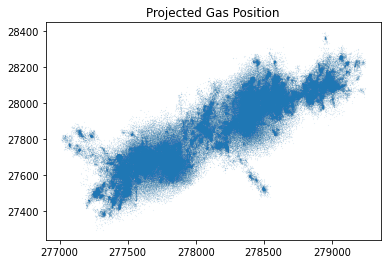

In [47]:
# url for positions of gas particles within Halo#1 in Snapshot#251
url =  field_url + "/Position/1"
gas_pos = get_group_data(url)
plt.scatter(gas_pos[:,0],gas_pos[:,1],s=0.001)
plt.title('Projected Gas Position')
plt.show()

In [48]:
url 

'http://vm041.bridges.psc.edu:8001/pig/251/gas/Position/1'

## Scratch

In [36]:
pig_dir = '/pylon5/as5pi3p/bluetides3/PIG_251/'
pig = bigfile.File(pig_dir)
print(pig['Header'].attrs)
pig['Header'].attrs['NumPartInGroupTotal']

<BigAttr (BoxSize=array([400000.]),CMBTemperature=array([2.7255]),HubbleParam=array([0.697]),MassTable=array([0.00023622, 0.00119639, 0.        , 0.        , 0.        ,
       0.        ]),NumFOFGroupsTotal=array([286036300], dtype=uint64),NumPartInGroupTotal=array([19358022252, 21165203462,           0,           0,   587619843,
            235967], dtype=uint64),Omega0=array([0.2814]),OmegaBaryon=array([0.0464]),OmegaLambda=array([0.7186]),Time=array([0.12987013]))>


array([19358022252, 21165203462,           0,           0,   587619843,
            235967], dtype=uint64)

In [40]:
import os
def get_part_subfield(pig_id:int, ptype:str):
    type_ind = {}
    type_ind['gas']  = 0
    type_ind['dm']   = 1
    type_ind['star'] = 4
    type_ind['bh']   = 5
    subdirectories = []
    directory_contents = os.listdir('/pylon5/as5pi3p/bluetides3/' + 'PIG_' + str(pig_id) + '/' + str(type_ind[ptype]))
    for item in directory_contents:
        subdirectories.append(item)
    return subdirectories

In [43]:
sub = get_part_subfield(251,'gas')
sub

['JUV',
 'Mass',
 'Density',
 'Potential',
 'ElectronAbundance',
 'Pressure',
 'SmoothingLength',
 'H2Fraction',
 'Position',
 'GroupID',
 'InternalEnergy',
 'StarFormationRate',
 'EgyWtDensity',
 'Entropy',
 'ID',
 'Generation',
 'Metallicity',
 'NeutralHydrogenFraction',
 'Velocity']

In [14]:
# lbt: number of particles in each Fof halo
# Read data from the first 500 halos
lbt = pig.open('FOFGroups/LengthByType')[:nhalo]
obt = np.cumsum(lbt,axis=0).astype(int)
#gas_group

### Gas data

In [13]:
group_id = 2117968
lbt = pig.open('FOFGroups/LengthByType')[:group_id]
obt = np.cumsum(lbt,axis=0).astype(int)
if group_id==1:
    GasPos = pig.open('0/Position')[:obt[0][0]]
else:
    GasPos = pig.open('0/Position')[obt[-2][0]:obt[-1][0]]
    

In [18]:
GasPos.shape

(804, 3)

In [17]:
print("Gas pos: %.10f, %.10f,%.10f"%(GasPos[3][0],GasPos[3][1],GasPos[3][2]))

Gas pos: 198335.0403950171, 40257.0979953014,189707.9848941324


In [20]:
# Gas data for the first 500 halos
GasPos = pig.open('0/Position')[:obt[-1][0]]
GroupID = pig.open('0/GroupID')[:obt[-1][0]]
print(GasPos.shape)
print(GroupID[:10])

(31179336, 3)
[1 1 1 1 1 1 1 1 1 1]


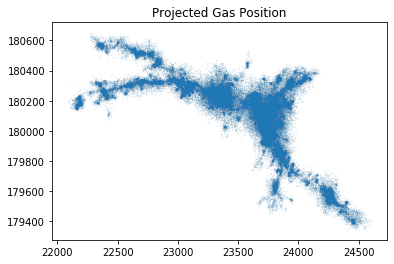

In [27]:
# e.g. Look at gas particle in the 3rd group
GasG3 = GasPos[GroupID==3]
plt.scatter(GasG3[:,0],GasG3[:,1],s=0.001)
plt.title('Projected Gas Position')
plt.show()

### Blackhole data

In [28]:
# Read blackhole info from the first 500 halos
# create catalog of BHs
BHMass = pig.open('5/BlackholeMass')[:obt[-1][5]]*10**10/0.697  # intrinsic mass from Bondi accretion
AccR = pig.open('5/Mass')[:obt[-1][5]] # dynamical mass from swallowing gas
GroupID = pig.open('5/GroupID')[:obt[-1][5]]
BHID = pig.open('5/ID')[:obt[-1][5]]


### BH Mass Function (not very meaningful for the first 500 halos but just an example)

In [29]:
BHmassPDF,edges = np.histogram(np.log(BHMass),bins=50,density=False)


Text(0, 0.5, '$N_{BH}$')

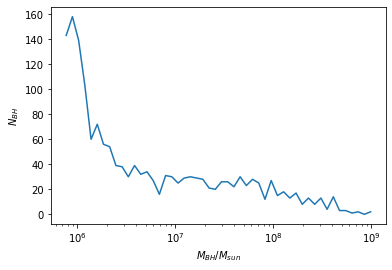

In [30]:
bin_centers = (edges[1:] + edges[:-1])/2.
plt.plot(np.exp(bin_centers),BHmassPDF)
plt.xscale('log')
#plt.yscale('log')
plt.xlabel(r'$M_{BH}/M_{sun}$')
plt.ylabel(r'$N_{BH}$')

## Read BH Details (Probably won't be used for BT3)

In [7]:
def read_bh(BHdir):
    BHIDs = []
    BHMass = []
    Mdots = []
    Densitys = []
    timebin = []
    MinPosx = []
    MinPot = []
    Entropys = []
    Gasvel = []
    acMass = []
    acBHMass = []
    Fdbk = []
    SPHID = []
    CountProgs = []
    SwallowID = []
    Swallowed = []
    time = []
    Posx = []

    def split(chunk):              
        BHIDs.append(struct.unpack("q",chunk[4:12]))
        BHMass.append(struct.unpack("d",chunk[12:20]))
        Mdots.append(struct.unpack("d",chunk[20:28]))
        Densitys.append(struct.unpack("d",chunk[28:36]))
        timebin.append(struct.unpack("i",chunk[36:40]))
        MinPosx.append(struct.unpack("d",chunk[44:52]))
        MinPot.append(struct.unpack("d",chunk[68:76]))
        Entropys.append(struct.unpack("d",chunk[76:84]))
        Gasvel.append(struct.unpack("3d",chunk[84:108]))
        acMass.append(struct.unpack("d",chunk[108:116]))
        acBHMass.append(struct.unpack("d",chunk[116:124]))    
        Fdbk.append(struct.unpack("d",chunk[124:132]))
        SPHID.append(struct.unpack("q",chunk[132:140]))
        SwallowID.append(struct.unpack("q",chunk[140:148]))
        CountProgs.append(struct.unpack("i",chunk[148:152]))
        Swallowed.append(struct.unpack("i",chunk[152:156]))
        time.append(struct.unpack("d",chunk[156:164]))
        Posx.append(struct.unpack("d",chunk[164:172]))
       
    chunk_size = 192  
    for filename in sorted(glob.glob(BHdir)):
        f = open(filename,'rb')
        while True:
            buf = f.read(chunk_size)
            if not buf:
                f.close()
                break
            split(buf)  
       
    data = np.zeros(len(BHIDs), dtype={'names':('BHIDs','BHMass','Mdot','Fdbk','Density',\
                'Entropy','acBHMass','MinPot','MinPosx','CountProgs','timebin','Swallowed','z','Posx'),\
                'formats':('q','d','d','d','d','d','d','d','d','i','i','i','d','d',)})
   
   
    data['BHIDs'] = np.concatenate(np.array(BHIDs))
    data['BHMass'] = np.concatenate(np.array(BHMass))*10**10/hh    
    data['Mdot'] = np.concatenate(np.array(Mdots))
    data['Fdbk'] = np.concatenate(np.array(Fdbk))
    data['Density'] = np.concatenate(np.array(Densitys))
    data['Entropy'] = np.concatenate(np.array(Entropys))
    data['acBHMass'] = np.concatenate(np.array(acBHMass))
    data['MinPot'] = np.concatenate(np.array(MinPot))
    data['MinPosx'] = np.concatenate(np.array(MinPosx))
    data['CountProgs'] = np.concatenate(np.array(CountProgs))
    data['timebin'] = np.concatenate(np.array(timebin))
    data['Swallowed'] = np.concatenate(np.array(Swallowed))
   
    time = np.concatenate(np.array(time))
    data['z'] = 1/time - 1
    data['Posx'] = np.concatenate(np.array(Posx))
    
    
    # Extract individual BHs
    BHID_list = list(set(data['BHIDs']))
    BH_list = []
    for i in BHID_list[:1]:
        mask = (data['BHIDs']==i)
        print(mask)
        bh = {'ID':i}
        bh['z'] = data['z'][mask]
        ind_sort = np.argsort(bh['z'])
        bh['z'] = data['z'][mask][ind_sort]
        bh['CountProg'] = data['CountProg'][mask][ind_sort]
        bh['Mass'] = data['BHMass'][mask][ind_sort]
        bh['Mdot'] = data['Mdot'][mask][ind_sort] 
        bh['Fdbk'] = data['Fdbk'][mask][ind_sort]
        bh['Density'] = data['Density'][mask][ind_sort]
        bh['Entropy'] = data['Entropy'][mask][ind_sort]
        bh['Pressure'] = data['Pressure'][mask][ind_sort]
        bh['acBHMass'] = data['acBHMass'][mask][ind_sort]
        bh['MinPosx'] = data['MinPosx'][mask][ind_sort]
        bh['MinPot'] = data['MinPot'][mask][ind_sort]
        bh['Swallowed'] = data['Swallowed'][mask][ind_sort]
        
        BH_list.append(bh)
        return BH_list
    

In [8]:
BHdir1 = '/home/nianyic/scratch/mp-gadget/bh_trial1/output/BlackholeDetails'
BHdir2 = '/home/nianyic/scratch/mp-gadget/bh_trial2/output/BlackholeDetails'
BHdir3 = '/home/nianyic/scratch/mp-gadget/bh_trial3/output/BlackholeDetails'

In [9]:
BH_list1 = read_bh(BHdir1)
BH_list2 = read_bh(BHdir2)
BH_list3 = read_bh(BHdir3)

    
    

ValueError: need at least one array to concatenate

### Try out Nbodykit (a package that can be used together with bigfile format for creating mesh data etc.)

In [18]:
gas_cat = BigFileCatalog('/home/nianyic/scratch/mp-gadget/bh_trial1/output/PIG_002/0', header='Header')
dm_cat = BigFileCatalog('/home/nianyic/scratch/mp-gadget/bh_trial1/output/PIG_002/1', header='Header')
star_cat = BigFileCatalog('/home/nianyic/scratch/mp-gadget/bh_trial1/output/PIG_002/4', header='Header')
bh_cat = BigFileCatalog('/home/nianyic/scratch/mp-gadget/bh_trial1/output/PIG_002/5', header='Header')

In [19]:
print(gas_cat)
print("columns = ", gas_cat.columns) # default Weight,Selection also present
print("total size = ", gas_cat.csize)

BigFileCatalog(size=1092237, FileStack(BigFile(path=/home/nianyic/scratch/mp-gadget/bh_trial1/output/PIG_002/0, dataset=./, ncolumns=19, shape=(1092237,)>, ... 1 files))
columns =  ['Density', 'EgyWtDensity', 'ElectronAbundance', 'Entropy', 'Generation', 'GroupID', 'H2Fraction', 'ID', 'InternalEnergy', 'JUV', 'Mass', 'Metallicity', 'NeutralHydrogenFraction', 'Position', 'Potential', 'Pressure', 'Selection', 'SmoothingLength', 'StarFormationRate', 'Value', 'Velocity', 'Weight']
total size =  1092237


In [22]:
gas_mesh = gas_cat.to_mesh(Nmesh=256, BoxSize=15.0, compensated=True, resampler='tsc', weight='Density')

In [25]:
one_plus_delta = gas_mesh.paint(mode='real')
print("mean of 1+delta = ", one_plus_delta.value.mean())
print("min of 1+delta = ", one_plus_delta.value.min())
print("max of 1+delta = ", one_plus_delta.value.max())

mean of 1+delta =  0.99999994
min of 1+delta =  -508.49713
max of 1+delta =  2074.396


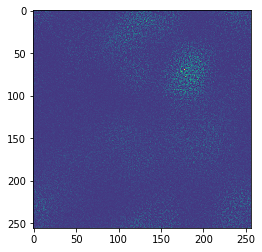

In [26]:
plt.imshow(one_plus_delta.preview(axes=[0,1]))